# Titanic - Machine Learning from Disaster


## Data Setup
The data set can be found online at [Kaggle.com](https://www.kaggle.com/competitions/titanic/overview).

In [1]:
# import libraries
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load titanic dataset
titanic_df = pd.read_csv("./Data/train.csv", index_col=0)

# drop columns that lack useful information: Name () and Ticket ()
titanic_df.drop(columns=["Name", "Ticket"], axis=1, inplace=True)

# get description of data
titanic_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
# convert features to nominal category data
titanic_df[["Sex", "Cabin", "Embarked"]] = titanic_df.select_dtypes(include="object").astype(pd.CategoricalDtype())

# convert feature to ordinal category data
titanic_df.loc[titanic_df["Pclass"] == 1, "Pclass"] = "1st"
titanic_df.loc[titanic_df["Pclass"] == 2, "Pclass"] = "2nd"
titanic_df.loc[titanic_df["Pclass"] == 3, "Pclass"] = "3rd"

# adjust ordering of the categories such that 1st class is the highest and 3rd is the lowest
titanic_df[["Pclass"]] = titanic_df[["Pclass"]].astype(pd.CategoricalDtype(ordered=True))
titanic_df["Pclass"] = titanic_df["Pclass"].cat.reorder_categories(["3rd", "2nd", "1st"])

# view current data types of features
print(f"Titanic data has shape: {titanic_df.shape}\n")
titanic_df.info(verbose=True)

Titanic data has shape: (891, 9)

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    int64   
 1   Pclass    891 non-null    category
 2   Sex       891 non-null    category
 3   Age       714 non-null    float64 
 4   SibSp     891 non-null    int64   
 5   Parch     891 non-null    int64   
 6   Fare      891 non-null    float64 
 7   Cabin     204 non-null    category
 8   Embarked  889 non-null    category
dtypes: category(4), float64(2), int64(3)
memory usage: 51.7 KB


## Exploratory Data Analysis
We create visualizations that help shed light on the relationship between features and their distributions. From this we can make more educated decisions about the type of preprocessing we do and generate (hopefully positive) effects on the outcome of our analysis and predictive capabilities of our models.

The features `Age` and `Cabin` which describe the age of the passenger and the cabin in which they were staying, respectively, have a number of null values. To inform the imputation of data, we examine the distribution of other features for null observations as they can help highlight: 1) Any patterns in the distribution of the data for observations with missing values; 2) Whether these other features will be helpful in informing what reasonable missing values might be for a given observation; and 3) What imputation method might make the most sense to use

Below we can see that the 

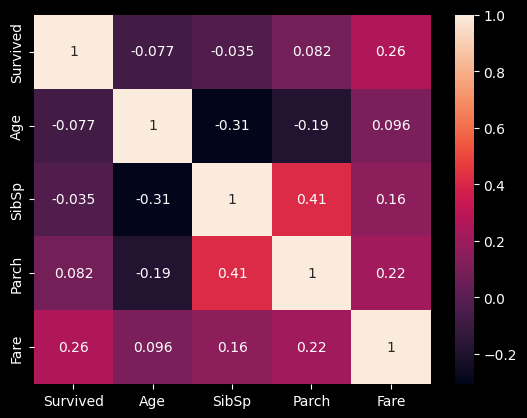

In [4]:
sns.heatmap(titanic_df.corr(numeric_only=True), annot=True);

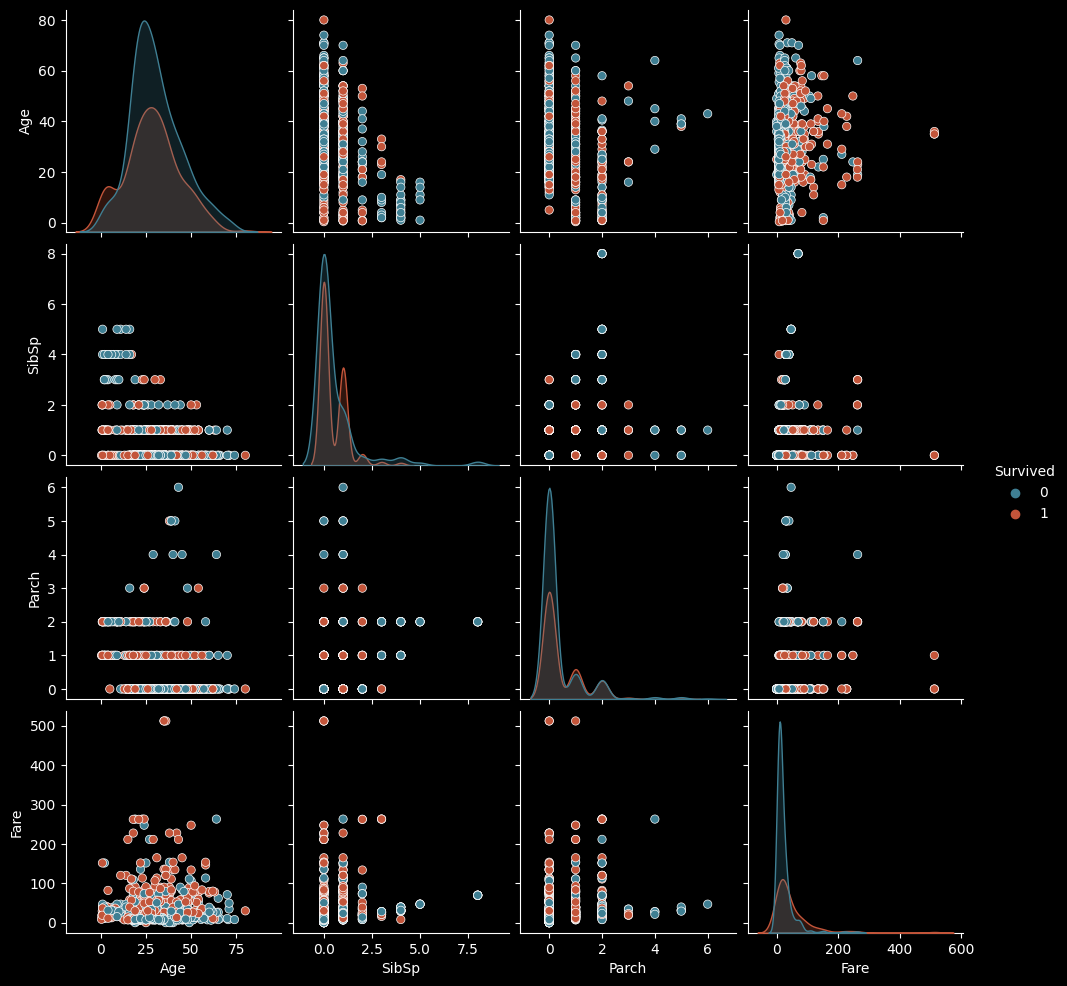

In [5]:
palette = sns.diverging_palette(220, 20)[::5]

# surpress UserWarning
warnings.filterwarnings("ignore")
sns.pairplot(
    titanic_df, 
    hue="Survived",
    dropna=True,
    palette=palette
);

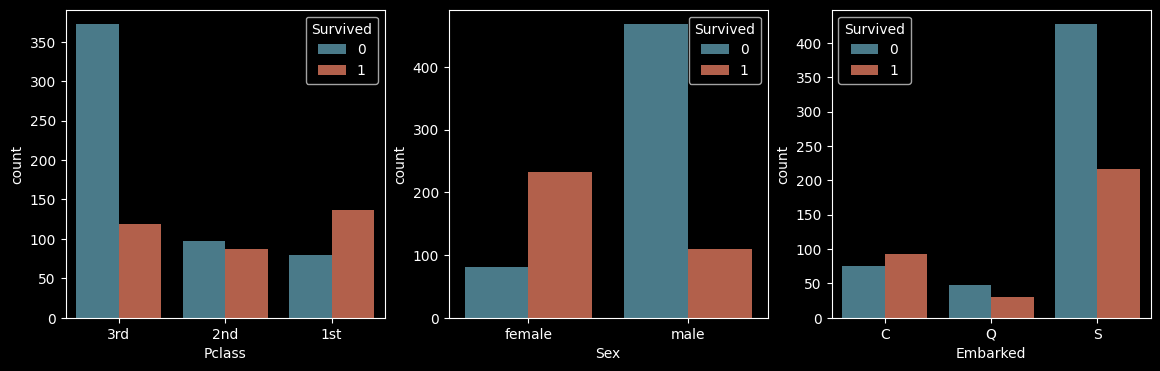

In [6]:
#sns.set(rc={'figure.figsize':(11.7,8.27),'axes.facecolor': 'black'})
fig, axs = plt.subplots(ncols=3,nrows=1,figsize=(14,4))
sns.countplot(titanic_df, x="Pclass", hue="Survived", palette=palette, ax=axs[0]);
sns.countplot(titanic_df, x="Sex", hue="Survived", palette=palette, ax=axs[1]);
sns.countplot(titanic_df, x="Embarked", hue="Survived", palette=palette, ax=axs[2]);

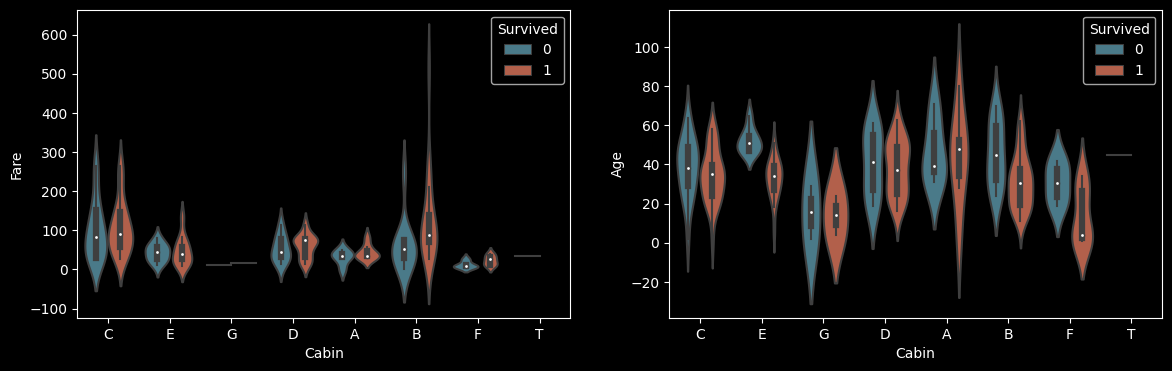

In [7]:
cabin_df = titanic_df[["Cabin", "Survived", "Fare", "Age"]].dropna(inplace=False)
cabin_df["Cabin"] = cabin_df["Cabin"].apply(lambda x: x[0])

fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(14,4))
sns.violinplot(cabin_df, x="Cabin", y="Fare", hue="Survived", palette=palette, ax=axs[0]);
sns.violinplot(cabin_df, x="Cabin", y="Age", hue="Survived", palette=palette, ax=axs[1]);

## Imputation, Transormations, and Model Selection

In [8]:
# import standard libraries
from os import cpu_count

# import machine learning and stats libraries
from scipy.stats import uniform
from sklearn.svm import LinearSVC, SVC
from sklearn.experimental import enable_iterative_imputer
from sklearn.metrics import accuracy_score
from sklearn_pandas import DataFrameMapper 
from sklearn.impute import IterativeImputer
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier

In [32]:
# seperate features from targets
titanic_X, titanic_y = titanic_df.iloc[:,1:], titanic_df.iloc[:,0]

# let's drop Cabin, the feature seems to have low utility and a high proportion of NA
titanic_X.drop(columns="Cabin", inplace=True)

# define the preprocessing feature map for imputation and transformations
feature_def = [
    ([names], [IterativeImputer(estimator=RandomForestRegressor(), max_iter=25, missing_values=-1), StandardScaler()], {}) 
    if types != "category" else ([names], [IterativeImputer(estimator=RandomForestClassifier(), max_iter=25, missing_values=-1), OneHotEncoder()], {}) 
    if names == "Pclass" else ([names], [IterativeImputer(estimator=RandomForestClassifier(), max_iter=25, missing_values=-1), OneHotEncoder()], {}) 
    for types, names in zip(titanic_X.dtypes, titanic_X.dtypes.index)
]


# convert all columns to codes and convert NA values in Age to match encoding for categoricals, -1
titanic_X[["Pclass", "Sex", "Embarked"]] = titanic_X.select_dtypes(include="category").apply(lambda x: x.cat.codes)
titanic_X["Age"] = titanic_X["Age"].apply(lambda x: -1 if pd.isna(x) else x)


# create dataframe mapper that will transform columns
mapper = DataFrameMapper(feature_def)

Nested cross-validation is a pretty interesting way to optimize machine learning models, check out the paper on [Arxiv](https://arxiv.org/pdf/1809.09446.pdf).

In [34]:
# get stratified splits for cross-validation
folds = 8
kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=123)

# define our models and the hyperparameter space for each
cpus = cpu_count()
models = [
    (RandomForestClassifier(n_jobs=(cpus-1)), dict(n_estimators=list(range(25,501)), criterion=["gini", "entropy"])),
    (GradientBoostingClassifier(), dict(n_estimators=list(range(25,501)), subsample=uniform(), max_depth=list(range(2,21)))),
    (LogisticRegression(solver="saga", max_iter=500, n_jobs=(cpus-1), penalty="elasticnet"), dict(l1_ratio=uniform(loc=0, scale=1), C=uniform(loc=0, scale=4))),
    (SVC(kernel="rbf"), dict(C=uniform(loc=0, scale=4), gamma=["scale", "auto"])),
    (SVC(kernel="poly"), dict(degree=list(range(2,11)), coef0=uniform(loc=-2, scale=2))),
    (LinearSVC(loss="squared_hinge", max_iter=5000, dual="auto"), dict(penalty=["l1", "l2"], C=uniform(loc=0, scale=4))),
]
model_names = [
    "Random Forest",
    "Gradient Boosting",
    "Logistic Regression",
    "SVC (RBF Kernel)",
    "SVC (Poly Kernel)",
    "Linear SVC"
]
model_perf = np.zeros((folds, len(models)))

# surpress ConvergenceWarning warning
warnings.filterwarnings("ignore")

# hyperparam tuning and model selection using nested cross-validation
for i, (train_idx, val_idx) in enumerate(kfold.split(titanic_X, titanic_y)):
    # get the training data that should be used for hyperparam optimization
    train_X = mapper.fit_transform(titanic_X.iloc[train_idx, ])
    train_y = titanic_y.iloc[train_idx]

    # get the validation data that should be used for model validation and comparison
    validation_X = mapper.transform(titanic_X.iloc[val_idx, ])
    validation_y = titanic_y.iloc[val_idx]

    # execute randomized search cross-validation for hyperparameter optimization
    for j, (model, hyperperams) in enumerate(models):
        rcv = RandomizedSearchCV(
            estimator=model, 
            param_distributions=hyperperams, 
            n_iter=1000, 
            n_jobs=(cpus-1), 
            cv=6
        )
        rcv.fit(train_X, train_y)

        # record model performance
        accuracy = accuracy_score(validation_y, rcv.predict(validation_X))
        model_perf[i, j] = accuracy     

/Users/peterakioyamen/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/peterakioyamen/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/peterakioyamen/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/peterakioyamen/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/peterakioyamen/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:3

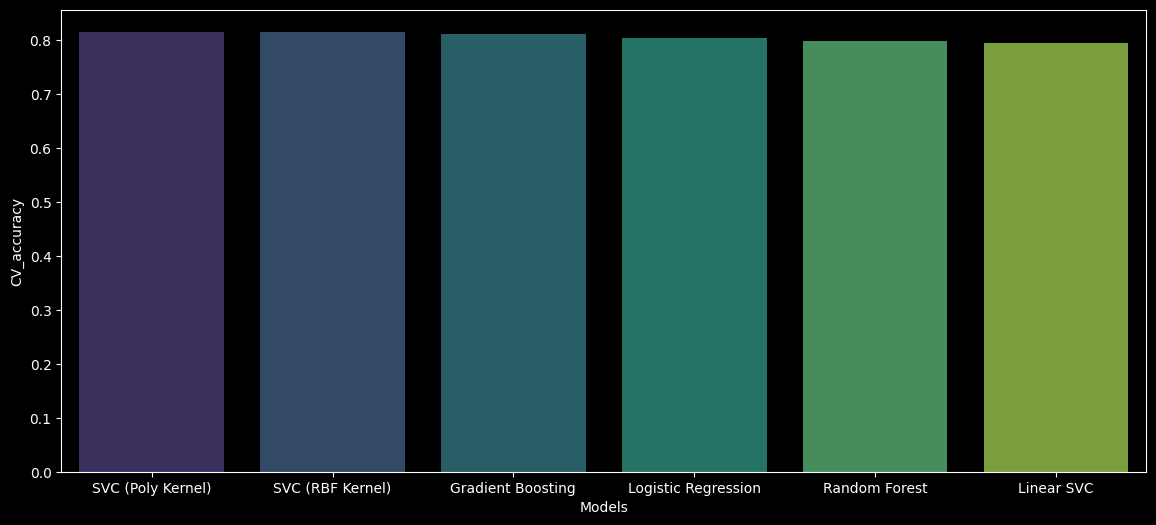

In [36]:
# Compare models performance and select best one
model_perf_df = pd.DataFrame(model_perf.transpose(), columns=["CV_"+str(i+1) for i in range(folds)])
model_perf_df["CV_accuracy"] = model_perf_df.mean(axis=1)
model_perf_df["Models"] = model_names
model_perf_df.sort_values(by="CV_accuracy", ascending=False, inplace=True)

plt.figure(figsize=(14, 6))
sns.barplot(model_perf_df, x="Models", y="CV_accuracy", palette="viridis",alpha=.8, ci="sd");

## Out-of-Sample Performance

In [41]:
# tune hyperparams of Gradient Boosting on the total training dataset
train_X = mapper.fit_transform(titanic_X)
train_y = titanic_y

# randomized hyperparam search on full training set
model = SVC(kernel="poly")  #GradientBoostingClassifier() #
hyperperams = dict(degree=list(range(2,15)), coef0=uniform(loc=-5, scale=5)) # dict(n_estimators=list(range(25,1000)), subsample=uniform(), max_depth=list(range(2,31))) #
rcv = RandomizedSearchCV(
    estimator=model, 
    param_distributions=hyperperams, 
    n_iter=10000, 
    n_jobs=(cpus-1), 
    cv=folds
)
rcv.fit(train_X, train_y)
print(f"The highest performing Gradient Boosting model has hyperperams: {rcv.best_params_}")

The highest performing Gradient Boosting model has hyperperams: {'coef0': -0.15361009114479884, 'degree': 3}


In [43]:
# Load test data and preprocess it
test_data = pd.read_csv("./Data/test.csv", index_col=0)

# drop columns that lack useful information: Name () and Ticket ()
test_data.drop(columns=["Name", "Cabin", "Ticket"], axis=1, inplace=True)

# convert features to nominal category data
test_data[["Sex", "Embarked"]] = test_data.select_dtypes(include="object").astype(pd.CategoricalDtype())

# convert feature to ordinal category data
test_data.loc[test_data["Pclass"] == 1, "Pclass"] = "1st"
test_data.loc[test_data["Pclass"] == 2, "Pclass"] = "2nd"
test_data.loc[test_data["Pclass"] == 3, "Pclass"] = "3rd"

# adjust ordering of the categories such that 1st class is the highest and 3rd is the lowest
test_data[["Pclass"]] = test_data[["Pclass"]].astype(pd.CategoricalDtype(ordered=True))
test_data["Pclass"] = test_data["Pclass"].cat.reorder_categories(["3rd", "2nd", "1st"])


# convert all columns to codes and convert NA values in Age to match encoding for categoricals, -1
test_data[["Pclass", "Sex", "Embarked"]] = test_data.select_dtypes(include="category").apply(lambda x: x.cat.codes)
test_data["Age"] = test_data["Age"].apply(lambda x: -1 if pd.isna(x) else x)
test_data["Fare"] = test_data["Fare"].apply(lambda x: -1 if pd.isna(x) else x)

# transform data
test_X = mapper.transform(test_data)

In [44]:
y_pred = rcv.predict(test_X)
results = pd.DataFrame(y_pred, index=test_data.index.values, columns=["Survived"])
results.index.name = "PassengerId"
results.to_csv("./Data/results_submission5.csv")

## 